In [168]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.linear_model as lm
from sklearn import model_selection as ms
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from IPython.display import display
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from sklearn.model_selection import KFold
import warnings
import matplotlib.pyplot as plt
sns.set_theme()
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv(r'train.csv')
test_df = pd.read_csv(r'test.csv')

In [3]:
# train_df.info()
categorical = list(train_df.select_dtypes('object').columns)
# categorical

There are 1460 samples in the training data set and 80 features. There are 43 columns with the 'object' data type,
meaning non-numeric categorical data. These features are contained in the "categorical" list. However, notice also that
the 'MSSubClass' feature is numerical-categorical. Thus, there are actually 44 categorical features.

I will select seven non-categorical features.

In [4]:
# sns.pairplot(train_df[['SalePrice', 'LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'FullBath', '1stFlrSF', '2ndFlrSF']])

The plots we care about here are in row 1 (or column 1). There appears to be a correlation between sales price and:
Overall Quality, 1st Floor Area, 2nd Floor Area, and some slight correlations with Year of Remodelling, and
Number of Full Baths.

In [5]:
# sm.linear_model.OLS()

In [6]:
MSSubClass_encoded = pd.get_dummies(train_df[['MSSubClass']].astype(str))
train_df_dropped = train_df.drop('Id', axis=1)
df_encoded = pd.get_dummies(train_df_dropped)
df_encoded = pd.concat([df_encoded, MSSubClass_encoded], axis=1).drop('MSSubClass', axis=1)
# df_encoded.info(verbose=True, null_counts=True)
# df_encoded

In [7]:
split = ms.train_test_split(df_encoded, train_size=0.8)
train_split = split[0]
test_split = split[1]
# train_split

In [8]:
# encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
# encoder.fit(train_df)

In [9]:
all_columns = df_encoded.columns
columns = df_encoded.drop(['SalePrice'], axis=1).columns
train_split.columns[train_split.isna().any()].tolist()
# test_split.columns[test_split.isna().any()].tolist()

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

Setting values to the mean or zeroes could highly skew the results of a regression model.
I will use KNN to perform multivariate imputation, filling in the above columns.

In [10]:
# Training the inputer with train split
imputer_train = KNNImputer(n_neighbors=15, weights="uniform")
imputer_train.fit(train_split)
train_split = pd.DataFrame(imputer_train.fit_transform(df_encoded), columns = all_columns)
test_split = pd.DataFrame(imputer_train.fit_transform(test_split), columns = all_columns)

In [11]:
# training the normalizer with train split
normalize_train = StandardScaler().fit(train_split.drop(['SalePrice'], axis=1))

train_norm = normalize_train.transform(train_split.drop(['SalePrice'], axis=1))
test_norm = normalize_train.transform(test_split.drop(['SalePrice'], axis=1))

train_norm = pd.DataFrame(train_norm, columns = columns)
test_norm = pd.DataFrame(test_norm, columns = columns)
train_norm

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
0,-0.247803,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.508709,0.575425,-0.288653,-0.944591,...,-0.222721,-0.052414,-0.091035,-0.330791,1.970518,-0.207020,-0.105263,-0.203395,-0.117851,-0.192177
1,0.412273,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.575571,1.171992,-0.288653,-0.641228,...,-0.222721,-0.052414,-0.091035,-0.330791,-0.507481,-0.207020,-0.105263,-0.203395,-0.117851,-0.192177
2,-0.115788,0.073480,0.651479,-0.517200,0.984752,0.830215,0.320620,0.092907,-0.288653,-0.301643,...,-0.222721,-0.052414,-0.091035,-0.330791,1.970518,-0.207020,-0.105263,-0.203395,-0.117851,-0.192177
3,-0.467828,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.575571,-0.499274,-0.288653,-0.061670,...,-0.222721,-0.052414,-0.091035,-0.330791,-0.507481,4.830459,-0.105263,-0.203395,-0.117851,-0.192177
4,0.588294,0.375148,1.374795,-0.517200,0.951632,0.733308,1.360644,0.463568,-0.288653,-0.174865,...,-0.222721,-0.052414,-0.091035,-0.330791,1.970518,-0.207020,-0.105263,-0.203395,-0.117851,-0.192177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.379818,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.575571,-0.973018,-0.288653,0.873321,...,-0.222721,-0.052414,-0.091035,-0.330791,1.970518,-0.207020,-0.105263,-0.203395,-0.117851,-0.192177
1456,0.632299,0.266407,-0.071836,0.381743,0.222975,0.151865,0.082742,0.759659,0.722112,0.049262,...,-0.222721,-0.052414,-0.091035,-0.330791,-0.507481,-0.207020,-0.105263,-0.203395,-0.117851,-0.192177
1457,-0.203798,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.575571,-0.369871,-0.288653,0.701265,...,-0.222721,-0.052414,-0.091035,-0.330791,-0.507481,4.830459,-0.105263,-0.203395,-0.117851,-0.192177
1458,-0.115788,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.575571,-0.865548,6.092188,-1.284176,...,-0.222721,-0.052414,-0.091035,-0.330791,-0.507481,-0.207020,-0.105263,-0.203395,-0.117851,-0.192177


In [12]:
X = train_norm
Y = train_split['SalePrice']
X_test = test_norm
Y_test = test_split['SalePrice']

X_non_norm = train_split.drop(['SalePrice'], axis=1)
X_test_non_norm = test_split.drop(['SalePrice'], axis=1)

In [13]:
lin_reg = lm.LinearRegression().fit(X, Y)
lin_pred = lin_reg.predict(X_test)
# lin_reg.score(test_norm.drop(['SalePrice'], axis=1), test_norm['SalePrice'])
r2_score(Y_test, lin_pred)
np.shape(lin_reg.coef_)

(302,)

In [14]:
knn_reg = KNeighborsRegressor()
param_grid = {'n_neighbors': np.arange(1, 15)}
knn_grid_cv = ms.GridSearchCV(knn_reg, param_grid, cv=10)
knn_grid_cv.fit(X, Y)
print(knn_grid_cv.best_params_)
print(knn_grid_cv.best_score_)
display(pd.DataFrame(knn_grid_cv.cv_results_))

{'n_neighbors': 11}
0.7405634361447293


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003001,4.473412e-04,0.004501,0.000500,1,{'n_neighbors': 1},0.704337,0.288652,0.673225,0.668503,0.728969,0.596297,0.750835,0.632051,0.345203,0.638231,0.602630,0.149873,14
1,0.002501,5.000831e-04,0.004701,0.000640,2,{'n_neighbors': 2},0.760294,0.597509,0.785232,0.744155,0.724942,0.711895,0.783782,0.755437,0.457308,0.693007,0.701356,0.096509,13
2,0.003001,2.249236e-07,0.004801,0.000400,3,{'n_neighbors': 3},0.791678,0.680672,0.789750,0.732312,0.732995,0.743530,0.791826,0.754361,0.515357,0.750465,0.728295,0.078027,12
3,0.002701,4.585263e-04,0.005401,0.000490,4,{'n_neighbors': 4},0.779533,0.716608,0.789691,0.720356,0.731071,0.745167,0.763657,0.782534,0.535011,0.747364,0.731099,0.069802,11
4,0.003101,3.001217e-04,0.005601,0.000490,5,{'n_neighbors': 5},0.767779,0.721353,0.793127,0.690670,0.733361,0.774366,0.749560,0.783860,0.549151,0.765257,0.732849,0.067945,10
5,0.003101,3.004316e-04,0.005601,0.000664,6,{'n_neighbors': 6},0.773894,0.783611,0.795534,0.700564,0.712149,0.785216,0.754382,0.779214,0.547689,0.769856,0.740211,0.070802,3
6,0.003101,2.999392e-04,0.005801,0.000600,7,{'n_neighbors': 7},0.770276,0.769669,0.790530,0.676201,0.700273,0.789617,0.766473,0.773471,0.543436,0.772189,0.735213,0.073298,8
7,0.003301,4.584066e-04,0.005601,0.001429,8,{'n_neighbors': 8},0.810577,0.764780,0.791389,0.670147,0.695494,0.779921,0.763272,0.792394,0.561254,0.773031,0.740226,0.072813,2
8,0.002901,2.999545e-04,0.005301,0.000641,9,{'n_neighbors': 9},0.804290,0.769589,0.791150,0.670639,0.694627,0.787157,0.760536,0.782024,0.558202,0.768746,0.738696,0.072640,6
9,0.002901,3.001454e-04,0.005401,0.000490,10,{'n_neighbors': 10},0.799760,0.760243,0.791905,0.686254,0.700491,0.779018,0.766560,0.784111,0.552897,0.765767,0.738701,0.071381,5


It appears that 11 neighbours gives us the best score. However, given the standard error of about 0.07, a score of at least
0.67 performs similarly. Thus, the "rule-of-thumb" best selection could be argued to be k=2 KNN with a score of 0.7014

In [15]:
ridge_reg = lm.RidgeCV(alphas=np.linspace(0.001,1000,30), cv=10)
ridge_reg.fit(X, Y)
print(ridge_reg.best_score_)
print(ridge_reg.alpha_)

0.8505264801075464
758.6209310344827


In [16]:
ridge_reg = lm.Ridge()
param_grid = {'alpha': np.linspace(0.001,10000,100)}
ridge_grid_cv = ms.GridSearchCV(ridge_reg, param_grid, cv=10)
ridge_grid_cv.fit(X, Y)
print(ridge_grid_cv.best_params_)
print(ridge_grid_cv.best_score_)
print(ridge_grid_cv.best_index_)
ridge_cv_table = pd.DataFrame(ridge_grid_cv.cv_results_)
ridge_cv_table

{'alpha': 707.0716363636363}
0.8505097456712031
7


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007701,0.000641,0.001701,0.000458,0.001,{'alpha': 0.001},0.882797,0.824154,0.912537,0.751018,0.900222,0.589256,0.886591,0.895929,0.420825,-1.254833,0.580850,0.630833,100
1,0.007201,0.000600,0.001701,0.000458,101.011091,{'alpha': 101.01109090909091},0.908442,0.841937,0.917140,0.771243,0.903549,0.778636,0.893137,0.898473,0.503665,0.899134,0.831536,0.120546,24
2,0.007101,0.000300,0.001701,0.000458,202.021182,{'alpha': 202.02118181818182},0.915468,0.853634,0.917034,0.778262,0.898969,0.815121,0.893655,0.897922,0.536410,0.897083,0.840356,0.110173,17
3,0.007301,0.000458,0.001501,0.000500,303.031273,{'alpha': 303.0312727272727},0.918958,0.861450,0.916649,0.781929,0.894194,0.834656,0.892960,0.897239,0.556682,0.895679,0.845040,0.103973,12
4,0.007101,0.000300,0.001801,0.000400,404.041364,{'alpha': 404.0413636363636},0.920918,0.866878,0.916232,0.784097,0.889546,0.846311,0.891740,0.896477,0.570754,0.894672,0.847762,0.099723,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.007015,0.000041,0.001901,0.000300,9595.959636,{'alpha': 9595.959636363636},0.807544,0.735987,0.783840,0.687069,0.672809,0.715143,0.735236,0.762134,0.560058,0.768608,0.722843,0.067231,95
96,0.007101,0.000300,0.001801,0.000400,9696.969727,{'alpha': 9696.969727272728},0.806138,0.734420,0.782338,0.685824,0.671181,0.713599,0.733770,0.760684,0.559009,0.767193,0.721416,0.067139,96
97,0.006901,0.000300,0.001400,0.000490,9797.979818,{'alpha': 9797.979818181819},0.804734,0.732859,0.780840,0.684582,0.669561,0.712062,0.732308,0.759239,0.557961,0.765782,0.719993,0.067046,97
98,0.007402,0.000491,0.001401,0.000490,9898.989909,{'alpha': 9898.98990909091},0.803333,0.731305,0.779346,0.683342,0.667949,0.710532,0.730852,0.757797,0.556914,0.764375,0.718575,0.066954,98


In [17]:
accept = ridge_grid_cv.best_score_ - ridge_cv_table['std_test_score'].iloc[ridge_grid_cv.best_index_]
print(accept)
print(ridge_cv_table[(ridge_cv_table['mean_test_score'] <= accept) & (ridge_cv_table.index > ridge_grid_cv.best_index_)].iloc[0])
ridge_cv_table[['param_alpha', 'mean_test_score']].iloc[71]

0.7584074107463838
mean_fit_time                            0.007202
std_fit_time                               0.0006
mean_score_time                          0.001701
std_score_time                           0.000641
param_alpha                           7272.727545
params               {'alpha': 7272.727545454545}
split0_test_score                        0.840509
split1_test_score                        0.773738
split2_test_score                        0.819431
split3_test_score                        0.716242
split4_test_score                        0.712863
split5_test_score                        0.752594
split6_test_score                         0.77045
split7_test_score                        0.796494
split8_test_score                        0.584314
split9_test_score                        0.802137
mean_test_score                          0.756877
std_test_score                           0.069555
rank_test_score                                72
Name: 72, dtype: object


param_alpha        7171.717455
mean_test_score       0.758408
Name: 71, dtype: object

Our best score here is with lambda or alpha ~ 707.07 with 0.8505. The standard error is 0.0921. This means that our
simplest model (higher lambda) is at index 71 (the lambda within our standard error threshold). This is lambda ~ 7172
and CV score = 0.7584

In [18]:
lasso_reg = lm.Lasso()
param_grid = {'alpha': np.linspace(0.001,20000,50)}
lasso_grid_cv = ms.GridSearchCV(lasso_reg, param_grid, cv=10)
lasso_grid_cv.fit(X, Y)
print(lasso_grid_cv.best_params_)
print(lasso_grid_cv.best_score_)
print(lasso_grid_cv.best_index_)
lasso_cv_table = pd.DataFrame(lasso_grid_cv.cv_results_)
# lasso_cv_table

{'alpha': 1632.6539795918368}
0.8443541296515326
4


In [19]:
accept = lasso_grid_cv.best_score_ - lasso_cv_table['std_test_score'].iloc[lasso_grid_cv.best_index_]
print(accept)
print(lasso_cv_table[(lasso_cv_table['mean_test_score'] <= accept) & (lasso_cv_table.index > lasso_grid_cv.best_index_)].iloc[0])
lasso_cv_table[['param_alpha', 'mean_test_score']].iloc[30]

0.7457931992421065
mean_fit_time                             0.006601
std_fit_time                               0.00049
mean_score_time                           0.001601
std_score_time                             0.00049
param_alpha                           12653.061592
params               {'alpha': 12653.061591836735}
split0_test_score                          0.80166
split1_test_score                         0.771215
split2_test_score                         0.805111
split3_test_score                         0.707488
split4_test_score                         0.706631
split5_test_score                         0.715163
split6_test_score                         0.764257
split7_test_score                         0.766628
split8_test_score                         0.596848
split9_test_score                         0.796461
mean_test_score                           0.743146
std_test_score                            0.060566
rank_test_score                                 32
Name: 31, dt

param_alpha        12244.898347
mean_test_score         0.74699
Name: 30, dtype: object

Our best score here is with lambda or alpha ~ 1632.65 with 0.8444. The standard error is 0.0986. This means that our
simplest model (higher lambda) is at index 30 (the lambda within our standard error threshold).
This is lambda ~ 12245 and CV score = 0.7470

In [20]:
lin_reg_cv = lm.LinearRegression()
cv_scores = cross_val_score(lin_reg_cv, X_non_norm, Y, cv=10)
print(np.mean(cv_scores))
print(np.std(cv_scores))
print(cv_scores)

0.5740162171877558
0.6390221064393009
[ 0.86387649  0.80127488  0.91110944  0.74827339  0.90051782  0.62523891
  0.88577184  0.89588169  0.39476086 -1.28654315]


In [21]:
v = np.linalg.inv(X.T.dot(X).values)

In [22]:
def sse_calc(y, y_hat):
    return np.sum(np.square(y - y_hat))

In [23]:
def z_calc(beta, n, k, v_j, sse):
    sigma = np.sqrt(1/(n-k-1) * sse)
    return beta/(sigma * np.sqrt(v_j))

In [24]:
kf = KFold(n_splits=10)
kf.split(X)
n_fold = 1
p = len(X.columns)
z_all = np.empty((0,p))
print(np.shape(z_all))

for train_index, test_index in kf.split(X):
    z_row = []
    train_fold_X = X_non_norm.iloc[train_index]
    train_fold_Y = Y.iloc[train_index]

    test_fold_X = X_non_norm.iloc[test_index]
    test_fold_Y = Y.iloc[test_index]

    lin_reg_fold = lm.LinearRegression().fit(train_fold_X, train_fold_Y)
    pred_fold = lin_reg_fold.predict(test_fold_X)

    n = len(train_fold_X) ### should be test length
    k = len(train_fold_X.columns)
    xtx = train_fold_X.T.dot(train_fold_X).values
    v = np.linalg.pinv(xtx)

    sse = sse_calc(test_fold_Y, pred_fold)
    beta = lin_reg_fold.coef_

    for j in range(len(beta)):
        v_j = v[j,j]
        b_j = beta[j]
        z_j = z_calc(b_j, n, k, v_j, sse)
        z_row.append(z_j)
    z_all = np.append(z_all, np.array([z_row]), axis=0)
    n_fold += 1

(0, 302)


In [25]:
z_all = pd.DataFrame(z_all, columns=columns)
z_all.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,9.000000,9.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2.240815,9.783085,10.590821,10.885915,6.528354,3.046017,6.650530,9.916069,2.774523,-1.108890,...,1.046747,0.091051,-0.181840,0.306769,1.156668,1.457959,-0.879254,-0.712504,-0.883752,0.010241
std,0.874715,3.586738,4.698628,4.574634,2.702237,1.043014,3.214977,2.948861,1.094164,0.798098,...,0.634400,0.436292,0.543579,0.326913,0.695981,0.869636,1.732635,0.410773,0.459427,0.209635
min,0.935428,3.379450,3.387678,3.159908,2.055800,1.176236,2.195324,4.806823,0.734019,-2.323435,...,0.180531,-0.337273,-1.139263,-0.340971,0.255046,0.354799,-3.327166,-1.629903,-1.915466,-0.333099
25%,1.489418,8.443376,7.628545,8.645514,5.194523,2.306489,4.210880,8.196488,2.506297,-1.816513,...,0.568305,-0.189853,-0.454888,0.145715,0.596242,0.799867,-2.226205,-0.821744,-1.168287,-0.065163
50%,2.407223,10.320636,10.656001,11.082886,6.506347,3.255468,6.639944,9.969461,2.938253,-0.793354,...,0.991280,-0.049502,-0.259856,0.356210,1.072019,1.188252,-0.775491,-0.622470,-0.663907,-0.016944
75%,2.720762,11.578973,14.410943,15.190964,8.735547,3.959173,9.075880,11.500695,3.381540,-0.563810,...,1.565854,0.109978,0.213523,0.521070,1.496508,2.137568,0.305592,-0.450598,-0.535978,0.051123
max,3.594324,14.488166,16.487793,15.677444,9.811755,4.309497,11.292743,14.507054,4.183681,-0.033292,...,2.059364,0.916599,0.682041,0.773034,2.433606,2.972476,1.761751,-0.301846,-0.515653,0.476572


In [30]:
# z_all.info(verbose=True, show_counts=True)

In [27]:
array = np.empty((0,3))

array = np.append(array, np.array([[1,3,5]]), axis=0)
array = np.append(array, np.array([[2,4,6]]), axis=0)

In [144]:
X_sm = sm.add_constant(X_non_norm)
sm_OLS_model = OLS(Y,X_sm)
result_sm = sm_OLS_model.fit()
a = result_sm.tvalues.to_frame().abs()
a.loc['const',0]
# X_test_sm = sm.add_constant(X_test, has_constant='add')
# Y_sm_pred = result_sm.predict(sm.add_constant(X_test_sm))

0.025105284535159693

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
1455    175000.0
1456    210000.0
1457    266500.0
1458    142125.0
1459    147500.0
Name: SalePrice, Length: 1460, dtype: float64

In [29]:
r2_score(Y_test, Y_sm_pred)

0.9344011723484195

In [107]:
result_sm.summary()
t_df = result_sm.tvalues.to_frame().abs()
t_df.sort_values(by=[0]).loc['const']

0    305.889535
Name: const, dtype: float64

In [139]:
result_sm.tvalues['const'] = np.inf
result_sm.tvalues


const                 inf
LotFrontage      1.345830
LotArea          6.102238
OverallQual      6.354396
OverallCond      6.651298
                   ...   
MSSubClass_70    1.018586
MSSubClass_75   -0.741981
MSSubClass_80   -0.407876
MSSubClass_85   -0.630981
MSSubClass_90    0.032265
Length: 303, dtype: float64

In [40]:
BSR_reg = lm.LinearRegression()
param_grid = {'fit_intercept': [True]}
BSR_grid_cv = ms.GridSearchCV(BSR_reg, param_grid, cv=10)
BSR_grid_cv.fit(X, Y)
pd.DataFrame(BSR_grid_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.079417,0.006169,0.002101,0.0003,True,{'fit_intercept': True},-1.098781e+25,-3.402445e+25,-1.032912e+24,-7.858075e+24,-4.396432e+24,-1.154353e+24,-1.304823e+24,-2.456593e+24,-1.798149e+25,-1.993961e+26,-2.805930e+25,5.794696e+25,1


In [146]:
def evaluate_cv_model(X, Y):
    reg = lm.LinearRegression()
    param = {'fit_intercept': [True]}
    grid_cv = ms.GridSearchCV(reg, param, cv=10)
    grid_cv.fit(X, Y)
    results = pd.DataFrame(grid_cv.cv_results_)
    score = results['mean_test_score'].iloc[0]
    std = results['std_test_score'].iloc[0]
    return score, std

def get_smallest_z(X ,Y):
    X_sm = sm.add_constant(X, has_constant='add')
    sm_OLS_model = OLS(Y, X_sm)
    result_sm = sm_OLS_model.fit()
    t_df = result_sm.tvalues.to_frame().abs()
    t_df.loc['const',0] = np.inf
    smallest_z_feature = t_df.sort_values(by=[0]).index[0]
    return smallest_z_feature

In [94]:
get_smallest_z(X_non_norm, Y)

'LandContour_Bnk'

In [111]:
evaluate_cv_model(X_non_norm, Y)

(0.5740162171877558, 0.6390221064393009)

In [147]:
X_BSR = X_non_norm
k = len(X_BSR.columns)
score_k = np.empty([k,3])
dropped_cols = []

for iteration in range(len(X_BSR.columns)+1):

    if len(X_BSR.columns) == 1:
        break

    col_to_drop = get_smallest_z(X_BSR, Y)
    print(col_to_drop)

    if col_to_drop == 'const':
        continue
    else:
        dropped_cols.append(col_to_drop)
        X_BSR = X_BSR.drop(col_to_drop, axis=1)

        score, std = evaluate_cv_model(X_BSR, Y)
        score_k[iteration,0] = k
        score_k[iteration,1] = score
        score_k[iteration,2] = std
        k -= 1
        print(k)

LandContour_Bnk
301
LotShape_Reg
300
MSSubClass_45
299
ExterCond_Fa
298
Functional_Maj2
297
Exterior2nd_MetalSd
296
Exterior1st_WdShing
295
BldgType_TwnhsE
294
CentralAir_Y
293
PavedDrive_P
292
MSSubClass_90
291
BldgType_Duplex
290
MiscFeature_Gar2
289
Exterior2nd_Stucco
288
Neighborhood_SawyerW
287
SaleCondition_Partial
286
HeatingQC_TA
285
HouseStyle_1.5Fin
284
SaleCondition_Family
283
Heating_GasW
282
MSSubClass_40
281
SaleCondition_Alloca
280
KitchenQual_Fa
279
Condition1_Feedr
278
MiscVal
277
MSZoning_RH
276
MSZoning_RM
275
LotConfig_Inside
274
Foundation_Slab
273
ExterQual_Fa
272
SaleType_Oth
271
RoofStyle_Mansard
270
Street_Grvl
269
LandSlope_Gtl
268
Utilities_NoSeWa
267
OpenPorchSF
266
Exterior2nd_Wd Shng
265
Neighborhood_Somerst
264
Exterior2nd_Brk Cmn
263
BsmtHalfBath
262
MasVnrType_BrkCmn
261
MSSubClass_50
260
BldgType_2fmCon
259
MSSubClass_190
258
ExterCond_Ex
257
Heating_Floor
256
SaleCondition_Abnorml
255
BsmtQual_Ex
254
Exterior2nd_Plywood
253
Exterior1st_CemntBd
252
Hou

(0.6, 0.9)

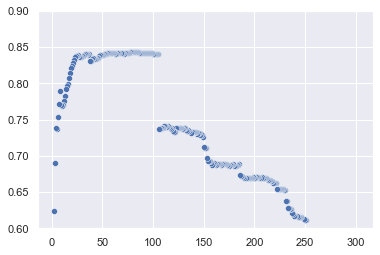

In [170]:
fig = sns.scatterplot(score_k[0:-1,0],score_k[0:-1,1])
fig.set_ylim(0.6,0.9)

(0.0, 120.0)

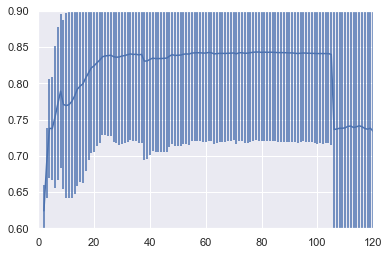

In [182]:
plt.errorbar(score_k[0:-1,0], score_k[0:-1,1], yerr=score_k[0:-1,2])
plt.ylim(0.6, 0.9)
plt.xlim(0,120)

In [151]:
score_k

array([[ 3.02000000e+002,  5.74016217e-001,  6.39022106e-001],
       [ 3.01000000e+002,  5.74016217e-001,  6.39022106e-001],
       [ 3.00000000e+002,  5.74020519e-001,  6.39022451e-001],
       [ 2.99000000e+002,  5.74017363e-001,  6.39021329e-001],
       [ 2.98000000e+002,  5.73847698e-001,  6.38934838e-001],
       [ 2.97000000e+002,  5.73862655e-001,  6.38893558e-001],
       [ 2.96000000e+002,  5.73869217e-001,  6.38874640e-001],
       [ 2.95000000e+002,  5.73869720e-001,  6.38874680e-001],
       [ 2.94000000e+002,  5.73869720e-001,  6.38874680e-001],
       [ 2.93000000e+002,  5.73869720e-001,  6.38874680e-001],
       [ 2.92000000e+002,  5.73869720e-001,  6.38874680e-001],
       [ 2.91000000e+002, -1.34409347e+007,  4.03228057e+007],
       [ 2.90000000e+002, -3.73027884e+006,  1.11908383e+007],
       [ 2.89000000e+002, -4.35670491e+007,  1.30701149e+008],
       [ 2.88000000e+002, -3.35824281e+007,  1.00747286e+008],
       [ 2.87000000e+002,  5.75481256e-001,  6.39833430

In [115]:
len(X_non_norm.columns)


302

array([[1.15442886e-311, 1.15442844e-311, 1.06099790e-313],
       [1.48539705e-313, 1.90979621e-313, 2.33419537e-313],
       [2.75859453e-313, 3.18299369e-313, 3.60739285e-313],
       [4.03179200e-313, 4.45619116e-313, 4.88059032e-313],
       [5.30498948e-313, 5.72938864e-313, 6.15378780e-313],
       [6.57818695e-313, 7.00258611e-313, 7.42698527e-313],
       [7.85138443e-313, 8.27578359e-313, 8.70018274e-313],
       [9.12458190e-313, 9.54898106e-313, 9.97338022e-313],
       [1.03977794e-312, 1.08221785e-312, 1.12465777e-312],
       [1.16709769e-312, 1.20953760e-312, 1.25197752e-312],
       [1.29441743e-312, 1.33685735e-312, 1.37929726e-312],
       [1.42173718e-312, 1.46417710e-312, 1.50661701e-312],
       [1.54905693e-312, 1.59149684e-312, 1.63393676e-312],
       [1.67637668e-312, 1.71881659e-312, 1.76125651e-312],
       [1.80369642e-312, 1.84613634e-312, 1.88857625e-312],
       [1.93101617e-312, 1.97345609e-312, 2.01589600e-312],
       [2.05833592e-312, 2.10077583e-312